# AutoFarm - Time Series of Temperature and Humidity

In my other notebook, we did some really great [analysis and data wrangling on the AutoFarm dataset on soil moisture](https://jackmead515.github.io/notebooks/auto_farm_soil_2.html). We are going to pickup that dataset and do some different analysis. I wanted to try a different type of analysis: time series. Just like the regression models, there is a level of increasing complexity that can be used for prediction. One of the simpliest models being ARIMA (AutoRegressive Integrated Moving Average) and the more complex being neural network approaches like the LSTM (Long Short Term Memory).

In this notebook, I'm going to explore and compare different time series models to predict the temperature of the AutoFarm dataset. So much has been written about these models and I will provide links to the resources I used to learn about them. No sense and rewriting what has already been written by more capable authors.

In [1]:
import sys
import warnings

warnings.filterwarnings("ignore")

class no_print():
    
    def __enter__(self):
        sys.__stdout__ = sys.stdout
        sys.stdout = open('/dev/null', 'w')
        return self

    def __exit__(self, type, value, traceback):
        sys.stdout.close()
        sys.stdout = sys.__stdout__

In [2]:
import pandas as pd

df = pd.read_parquet('auto_farm_metrics.parquet')

df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df['watering_start'] = pd.to_datetime(df['watering'].apply(lambda x: x.split(' - ')[0]))
df['watering_end'] = pd.to_datetime(df['watering'].apply(lambda x: x.split(' - ')[1]))

df = df.drop(columns=['watering'])

df

,timestamp,dht11_air_temp,dht11_air_humid,ds18b20_air_temp_0,ds18b20_air_temp_1,soil_moisture_0,soil_moisture_1,soil_moisture_2,soil_moisture_3,avg_soil_moisture,brightness,watering_start,watering_end
0,2020-10-10 07:00:00,32.000000,63.754826,27.704363,27.293797,417.498069,463.480695,481.974903,326.843629,422.449324,0.000000,2020-10-10 06:57:00,2020-10-11 23:53:00
1,2020-10-10 07:10:00,32.000000,63.632296,27.633689,27.578280,434.618677,475.237354,453.719844,322.889105,421.616245,0.000000,2020-10-10 06:57:00,2020-10-11 23:53:00
2,2020-10-10 07:20:00,32.000000,63.215116,27.556795,27.496446,438.647287,475.158915,450.346899,322.496124,421.662306,0.000000,2020-10-10 06:57:00,2020-10-11 23:53:00
3,2020-10-10 07:30:00,32.000000,63.022814,27.440209,27.397051,441.794677,475.442966,451.977186,323.192015,423.101711,0.000000,2020-10-10 06:57:00,2020-10-11 23:53:00
4,2020-10-10 07:40:00,32.000000,63.118447,27.238981,27.232012,445.568932,476.543689,454.366990,324.236893,425.179126,0.000000,2020-10-10 06:57:00,2020-10-11 23:53:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4015,2020-11-08 01:10:00,32.274662,67.290135,27.719818,27.958708,487.388781,463.040619,412.077369,322.647969,421.288685,124.100862,2020-11-04 20:34:00,2020-11-08 03:33:00
4016,2020-11-08 01:20:00,32.013436,67.911708,27.760113,28.013246,488.570058,464.155470,412.541267,322.827255,422.023512,123.418997,2020-11-04 20:34:00,2020-11-08 03:33:00
4017,2020-11-08 01:30:00,32.000000,68.000000,27.834587,28.057213,489.788462,465.150000,413.225000,323.507692,422.917788,122.864865,2020-11-04 20:34:00,2020-11-08 03:33:00
4018,2020-11-08 01:40:00,32.000000,68.000000,27.856563,28.067134,490.801942,465.866019,413.541748,323.900971,423.527670,122.810977,2020-11-04 20:34:00,2020-11-08 03:33:00


To start, let's begin with a basic train test split. In time series, splitting the data randomly wouldn't make any sense. Since we are predicting into the future, we need each split to be a contiguous block of time. Simple for us, since we can just sort by time and split the data that way.

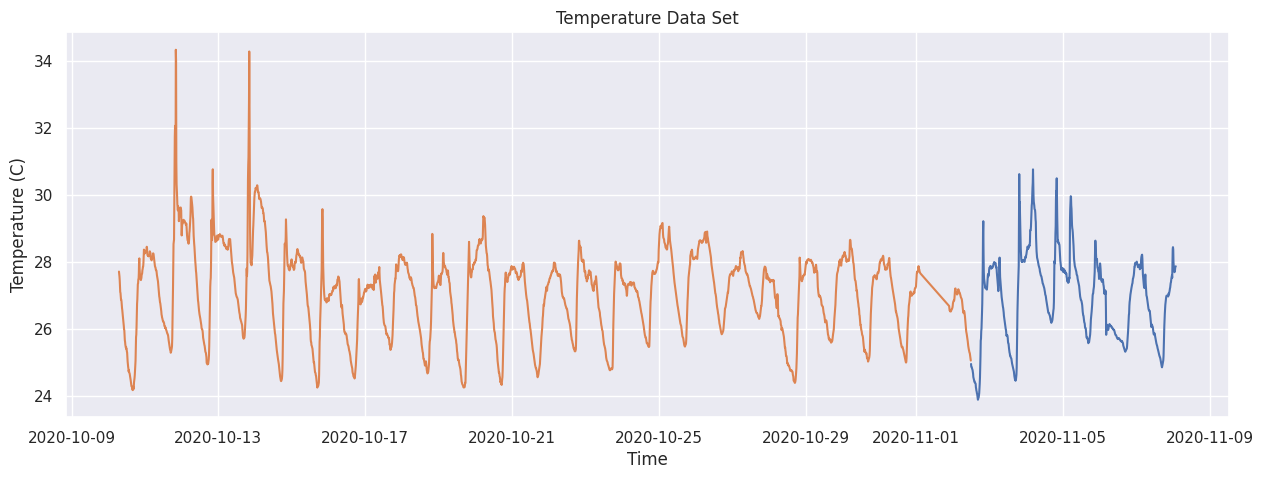

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="darkgrid")

df = df.sort_values('timestamp')

train_indicies = len(df) * 0.8
df['train_set'] = df.index < train_indicies
df['test_set'] = df.index >= train_indicies

train = df[df['train_set']]['ds18b20_air_temp_0']
test = df[df['test_set']]['ds18b20_air_temp_0']

plt.figure(figsize=(15, 5))
sns.lineplot(data=df, x='timestamp', y='ds18b20_air_temp_0', hue='train_set')
plt.title('Temperature Data Set')
plt.xlabel('Time')
plt.ylabel('Temperature (C)')
plt.legend([],[], frameon=False)
plt.show()

## Arima Model

To start, as a baseline, the Arima model will be used. Some great resources that I used to learn about the Arima model are:

[ARIMA Model – Complete Guide to Time Series Forecasting in Python](https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/)

[What is an ARIMA Model?](https://towardsdatascience.com/what-is-an-arima-model-9e200f06f9eb)

[statsmodels.tsa.arima.model.ARIMA](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html)

[pmdarima.arima.auto_arima](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html)


Even though it's quite simple, it can be intimidating at first. There are many parameters that can be tuned and knowing what each ones does takes some time to learn about. Because there are so many hyperparameters, the `pmadrima` library has a function called `auto_arima` that will automatically tune the hyperparameters for you. It does more than just cross validation but also estimates one of the core hyperparameters (`d`) that is used to make the time series stationary.

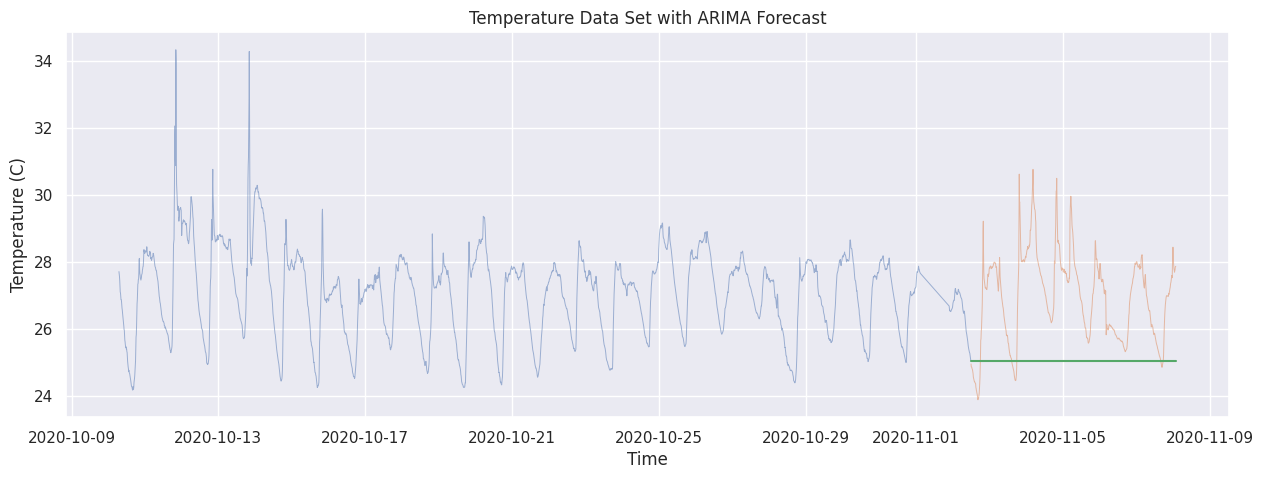

In [62]:
import pmdarima as pm

model = pm.auto_arima(
        train,
        start_p=1,
        start_q=1,
        max_p=10,
        max_q=10,
        stepwise=True,
        suppress_warnings=True,
        error_action='ignore',
        seasonal=False,
        maxiter=10
)

forecast = model.predict(n_periods=len(test))

plt.figure(figsize=(15, 5))
plt.plot(df[df['train_set']]['timestamp'], train, label='Train', linewidth=0.7, alpha=0.5)
plt.plot(df[df['test_set']]['timestamp'], test, label='Test', linewidth=0.7, alpha=0.5)
plt.plot(df[df['test_set']]['timestamp'], forecast, label='Forecast')
plt.title('Temperature Data Set with ARIMA Forecast')
plt.xlabel('Time')
plt.ylabel('Temperature (C)')
plt.legend([],[], frameon=False)
plt.show()

Unfortunately, I could never get this model to perform well at all. I tried many different parameters and it always performed poorly. I'm not sure if it's because the data is too noisy or if I'm not using the model correctly. In addition, utilizing the automatic ARIMA model to find the right hyperparameters took an enourmous amount of CPU and time forcing me to have to move on. A disappointing pass at this, I'm sure to come back to it in the future.

Fortunately, we can try many different models in the `sklearn` library with the `skforecast` library. It's a plug-and-playable library for time series forecasting where you can plug in any regression model from `sklearn` and it will automatically fit the model to the time series data. To start, we can utilize a simple linear regression model to predict the temperature.

A great introduction to the `skforecast` library can be found here [Skforecast: time series forecasting with Python, Machine Learning and Scikit-learn](https://cienciadedatos.net/documentos/py27-time-series-forecasting-python-scikitlearn.html)

Linear Regression: MAE: 1.05, Lags: 600


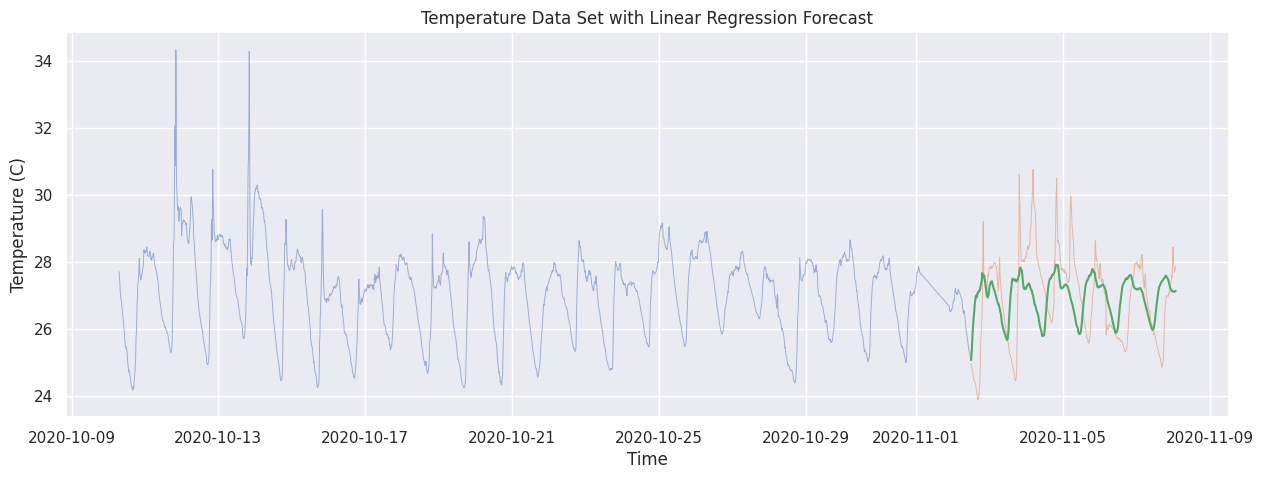

In [10]:
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster

lags_grid = np.arange(100, 1100, 100).tolist()

forecaster = ForecasterAutoreg(
    regressor=LinearRegression(),
    lags=100
)

error_metric = lambda y_true, y_pred, y_train: mean_absolute_error(y_true, y_pred)

# convert stdout to /dev/null to suppress output
# I dunno why I think this is a bug in skforecast
with no_print():
    fold_results = grid_search_forecaster(
        forecaster=forecaster,
        y=train,
        param_grid={},
        lags_grid=lags_grid,
        steps=(24 * 60) // 10,
        refit=False,
        metric=error_metric,
        initial_train_size=len(train) // 2,
        fixed_train_size=False,
        return_best=True,
        n_jobs='auto',
        verbose=False,
        show_progress=False
    )

forecast = forecaster.predict(steps=len(test))

lags = len(forecaster.lags)

print(f'Linear Regression: MAE: {mean_absolute_error(test, forecast):.2f}, Lags: {lags}')

plt.figure(figsize=(15, 5))
plt.plot(df[df['train_set']]['timestamp'], train, label='Train', linewidth=0.7, alpha=0.5)
plt.plot(df[df['test_set']]['timestamp'], test, label='Test', linewidth=0.7, alpha=0.5)
plt.plot(df[df['test_set']]['timestamp'], forecast, label='Forecast')
plt.title('Temperature Data Set with Linear Regression Forecast')
plt.xlabel('Time')
plt.ylabel('Temperature (C)')
plt.legend([],[], frameon=False)
plt.show()

With a mean absolute error hovering around 1, the linear regression model doesn't seem to be complex enough. But peering into the graph, we do see that the model is able to capture the general trend of the temperature: once a day it rises and falls with the sun. I believe the complexity of this data lies in the noise that is sometimes generated in the beginning of each day.

For context, this noise isn't actually sensor malfunction. This was mostly due to direct sunlight coming in as the sun rises over the mountain briefly. We can actually visualize that in the image dataset where around the same time we see intense sun beams coming in. Of course, it doesn't happen every day due to cloud coverage and other factors (maybe I didn't open the blinds that day). But if we want to potentially predict this noise, we need a more complex model.

We have to understand that a mean absolute error of ~1 means that the model is off, on average, by 1 degree. This really isn't bad (our sensors are just really precise). Intepreting the errors can be tricky. But there are many resources I learned from:

[Forecasting: Principles and Practice](https://otexts.com/fpp2/accuracy.html)

[Time Series Forecasting Metrics](https://skforecast.org/0.13.0/user_guides/metrics)

In [5]:
def grid_fit_forecaster(train, forecaster, lags_grid, param_grid):
    error_metric = lambda y_true, y_pred, y_train: mean_absolute_error(y_true, y_pred)

    with no_print():
        fold_results = grid_search_forecaster(
            forecaster=forecaster,
            y=train,
            param_grid=param_grid,
            lags_grid=lags_grid,
            steps=(24 * 60) // 10,
            refit=False,
            metric=error_metric,
            initial_train_size=len(train) // 2,
            fixed_train_size=True,
            return_best=True,
            n_jobs='auto',
            verbose=False,
            show_progress=False
        )

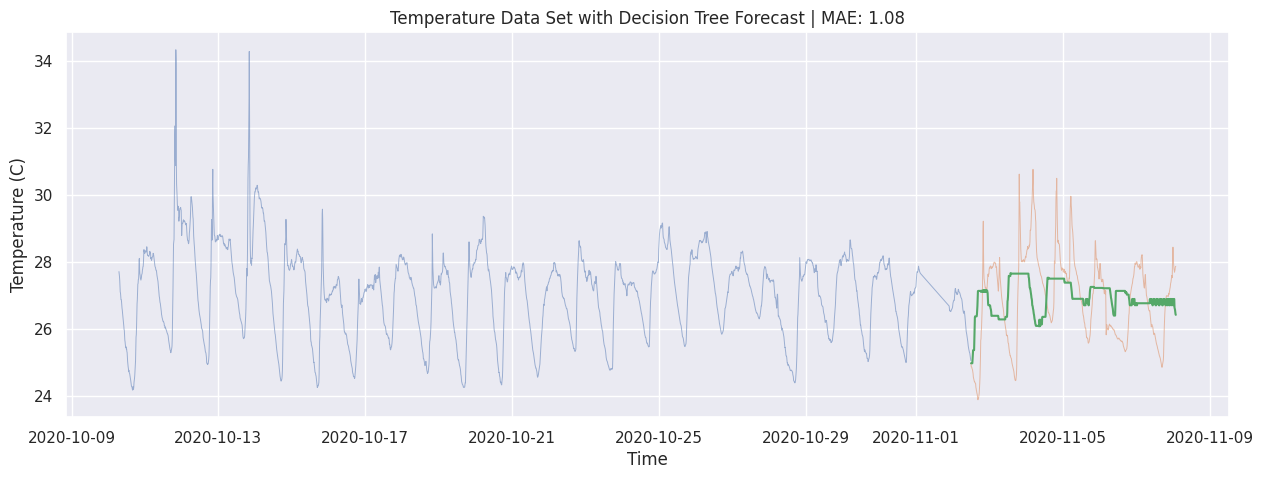

In [11]:
from sklearn.tree import DecisionTreeRegressor

lags_grid = np.arange(100, 1100, 100).tolist()

forecaster = ForecasterAutoreg(
    regressor=DecisionTreeRegressor(),
    lags=100
)

grid_fit_forecaster(train, forecaster, lags_grid, {
    'max_depth': np.arange(1, 100, 10).tolist()
})

forecast = forecaster.predict(steps=len(test))

test_error = mean_absolute_error(test, forecast)

plt.figure(figsize=(15, 5))
plt.plot(df[df['train_set']]['timestamp'], train, label='Train', linewidth=0.7, alpha=0.5)
plt.plot(df[df['test_set']]['timestamp'], test, label='Test', linewidth=0.7, alpha=0.5)
plt.plot(df[df['test_set']]['timestamp'], forecast, label='Forecast')
plt.title(f'Temperature Data Set with Decision Tree Forecast | MAE: {test_error:.2f}')
plt.xlabel('Time')
plt.ylabel('Temperature (C)')
plt.legend([],[], frameon=False)
plt.show()

Admittedly, I had some bias assuming the decision tree would have a better chance at capturing the dataset's variance. But it seems to have performed worse than the linear regression model. The seasonality is blocky and doesn't really learn the true pattern. The decision tree, while very robust and useful, simply isn't the right model for this dataset.

A couple of models I want to see are K-Nearest Neighbors, ElasticNet, and the most complex: XGBoost. Let's compare them below. Due to the extremely long training time required for XGBoost, I'm manually tuning the hyperparameters for now. I could experiment with bayesian optimization, or just reduce the grid search space. But after the training taking a few hours, I'm not prepared at the moment to do that. I need to parallelize this grid search out with Dask sometime! Perhaps in the future.

Elastic Net MAE: 1.00
K-Nearest Neighbors MAE: 1.24
XGBoost MAE: 1.04


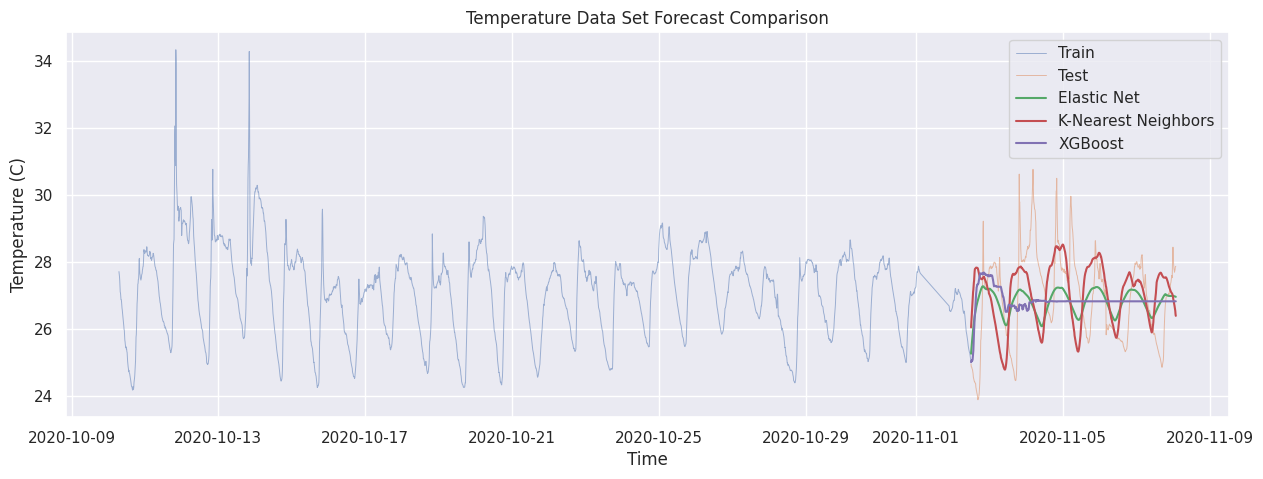

In [12]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import ElasticNet
from xgboost import XGBRegressor

lags_grid = np.arange(100, 1100, 100).tolist()

net_forecaster = ForecasterAutoreg(regressor=ElasticNet(), lags=100)
knn_forecaster = ForecasterAutoreg(regressor=KNeighborsRegressor(n_jobs=-1), lags=100)
xgb_forecaster = ForecasterAutoreg(
    regressor=XGBRegressor(
        n_jobs=-1,
        max_depth=20,
        n_estimators=200,
        enable_categorical=True
    ),
    lags=300
)

xgb_forecaster.fit(y=train)

grid_fit_forecaster(train, net_forecaster, lags_grid, {
    'alpha': np.arange(0.1, 1.0, 0.1).tolist()
})

grid_fit_forecaster(train, knn_forecaster, lags_grid, {
    'n_neighbors': np.arange(1, 50, 10).tolist()
})

net_forecast = net_forecaster.predict(steps=len(test))
knn_forecast = knn_forecaster.predict(steps=len(test))
xgb_forecast = xgb_forecaster.predict(steps=len(test))

net_test_error = mean_absolute_error(test, net_forecast)
knn_test_error = mean_absolute_error(test, knn_forecast)
xgb_test_error = mean_absolute_error(test, xgb_forecast)

print(f'Elastic Net MAE: {net_test_error:.2f}')
print(f'K-Nearest Neighbors MAE: {knn_test_error:.2f}')
print(f'XGBoost MAE: {xgb_test_error:.2f}')

plt.figure(figsize=(15, 5))
plt.plot(df[df['train_set']]['timestamp'], train, label='Train', linewidth=0.7, alpha=0.5)
plt.plot(df[df['test_set']]['timestamp'], test, label='Test', linewidth=0.7, alpha=0.5)
plt.plot(df[df['test_set']]['timestamp'], net_forecast, label=f'Elastic Net')
plt.plot(df[df['test_set']]['timestamp'], knn_forecast, label=f'K-Nearest Neighbors')
plt.plot(df[df['test_set']]['timestamp'], xgb_forecast, label=f'XGBoost')
plt.title('Temperature Data Set Forecast Comparison')
plt.xlabel('Time')
plt.ylabel('Temperature (C)')
plt.legend()
plt.show()

Very oddly, the lowest MAE was not KNN even though KNN appears to better understand the seasonality of the data. XGBoost flatlines after a certain point and ElasticNet seems to predict a smoothed sinusodial pattern (but ultimately leading to a lower MAE score regardless). Very strange indeed! Regardless, we need a model that will detect the seasonality in the dataset regardless of how small the fluctuations are. The k-nearest neighbors model is able to do this, but needs a large lag to do so.

In [13]:
len(knn_forecaster.lags), len(xgb_forecaster.lags), len(net_forecaster.lags)

(900, 300, 900)

For reference, each lag in my dataset is 10 minutes. So 1000 lags would be about a week. Further investigation into the folds of the grid search would be needed to determine if our adjustments of the lag reach a point of diminishing returns. 

With all the hopes of XGBoost being our top contender, here are some great resources that I used to learn about fitting XGBoost models in a time series setting:

[xgboost.XGBRegressor](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBRegressor)

[Forecasting time series with XGBoost](https://cienciadedatos.net/documentos/py56-forecasting-time-series-with-xgboost.html)

[Forecaster explainability: Feature importance, SHAP Values and Partial Dependence Plots](https://skforecast.org/0.13.0/user_guides/explainability.html)

For now, it would appear that the linear regression model is the best model for this data: providing a relatively small lag window, seasonality detection, and the lowest MAE. But I suspect we can do better. There are other model frameworks we can use to predict time series data. [Prophet](https://github.com/facebook/prophet), from Facebook research, is an amazing and easy to use library for time series forecasting. Sure it's fun to build our own models, but in a production setting when needing to meet deadlines, the lowest score with the fastest deployment sometimes wins.

prophet    INFO  Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
cmdstanpy  DEBUG input tempfile: /tmp/tmpjwblsoab/da_seem9.json
cmdstanpy  DEBUG input tempfile: /tmp/tmpjwblsoab/460g0jfo.json
cmdstanpy  DEBUG idx 0
cmdstanpy  DEBUG running CmdStan, num_threads: None
cmdstanpy  DEBUG CmdStan args: ['/home/jack/.local/share/virtualenvs/datadev-5ox7fytP/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38846', 'data', 'file=/tmp/tmpjwblsoab/da_seem9.json', 'init=/tmp/tmpjwblsoab/460g0jfo.json', 'output', 'file=/tmp/tmpjwblsoab/prophet_modelphz5o616/prophet_model-20240905101237.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:12:37 - cmdstanpy - INFO - Chain [1] start processing
cmdstanpy  INFO  Chain [1] start processing
10:12:38 - cmdstanpy - INFO - Chain [1] done processing
cmdstanpy  INFO  Chain [1] done processing


Prophet MAE: 1.00


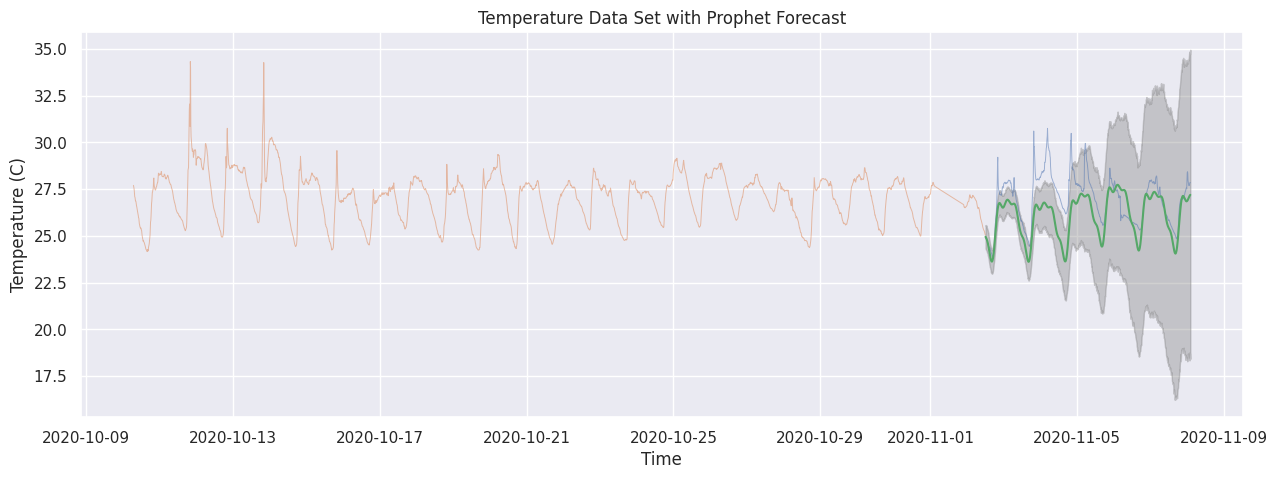

In [14]:
from prophet import Prophet

pdf = df[['timestamp', 'ds18b20_air_temp_0']].copy()
pdf = pdf.rename(columns={'timestamp': 'ds', 'ds18b20_air_temp_0': 'y'})

train_indicies = len(pdf) * 0.8
pdf['train_set'] = pdf.index < train_indicies
pdf['test_set'] = pdf.index >= train_indicies
train = pdf[pdf['train_set']]
test = pdf[pdf['test_set']]

model = Prophet()
model.fit(train)

forecast = model.predict(test)

test_error = mean_absolute_error(test['y'], forecast['yhat'])

print(f'Prophet MAE: {test_error:.2f}')

plt.figure(figsize=(15, 5))
sns.lineplot(data=pdf, x='ds', y='y', hue='train_set', linewidth=0.7, alpha=0.5)
plt.plot(test['ds'], forecast['yhat'], label='Forecast')
plt.fill_between(test['ds'], forecast['yhat_upper'], forecast['yhat_lower'], color='gray', alpha=0.2)
plt.fill_between(test['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='gray', alpha=0.2)
plt.title('Temperature Data Set with Prophet Forecast')
plt.xlabel('Time')
plt.ylabel('Temperature (C)')
plt.legend([],[], frameon=False)
plt.show()

Incredible! Extremely fast fitting, and it gives us confidence bands to go with our predictions. The model seems to be very similar to the linear regression, implying that a linear model was probably utilized under the hood. And with a MAE of 1, it's not far off from our original model. This library is quite extensive. And there are so many features that I haven't even begun to touch on. The documentation isn't the best, and they also reccomend another similar library that is written with Pytorch called [NeuralProphet](https://neuralprophet.com/). I won't dive into this library yet, because I've been itching to try out an LSTM model.

What we have not yet tried is any neural networks. The LSTM model is a type of recurrent neural network that is able to remember past information. Obviously, as you might have guessed, it's useful for time series data. I find it redundant to write able what this model is and how it works because it has been written about extensively by other writers. Here are some really awesome links that I recommend:

[LSTM for Time Series Prediction in PyTorch](https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/)

[Multi-Step LSTM Time Series Forecasting Models for Power Usage](https://machinelearningmastery.com/how-to-develop-lstm-models-for-multi-step-time-series-forecasting-of-household-power-consumption/)

[On the Suitability of Long Short-Term Memory Networks for Time Series Forecasting](https://machinelearningmastery.com/suitability-long-short-term-memory-networks-time-series-forecasting/)

[Building a LSTM by hand on PyTorch](https://towardsdatascience.com/building-a-lstm-by-hand-on-pytorch-59c02a4ec091)

[Sequence Models and Long Short-Term Memory Networks](https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html)

[torch.nn.LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)

But before I continue, there are a few concepts that should be understood.

First, our dataset that we are working with is `stationary` (or are least pretty close to stationary). In simple terms, this just means that the mean and variance of the dataset is constant over time. Or even simpler terms, the dataset doesn't have some sort of trend or seasonality that changes over time. There are actual statistical tests that can be performed to determine if a dataset is stationary (like the Augmented Dickey-Fuller test).

Why is this important? Many `auto-regressive` models, like the ARIMA model, require the dataset to be `stationary`. This is because the model is trying to predict the future based on the past using linear models. If there is some sort of overall trend or seasonality, The model is going to find it difficult to predict into the future unless explicitly told how to handle it (this is why you see seasonality parameters in all the other models in skforecast, ARIMA, and Prophet).

For the LSTM model, this isn't as important. As the model is able to learn any sequence of data regardless of the trend or seasonality, as long as a large enough window of data is provided that encapsulates the trend or seasonality. But, it is generally reccomended that if a dataset is stationary to attempt to utilize auto-regressive models first (which is exactly what we did).

In [15]:
import torch as t
from torch.utils.data import DataLoader, TensorDataset

timesteps = lambda hours: (hours * 60) // 10

def create_dataset(data, lags, future):
    """
    `lags` describes the number of timesteps to look back. This is our `window`
    
    `future` describes the number of timesteps to look forward.
    This is how far we want to predict into the future.
    """
    x, y = [], []
    
    for i in range(len(data) - lags - future):
        x.append(data[i:i+lags])
        y.append(data[i+lags:i+lags+future])
    
    return t.tensor(x).float().unsqueeze(-1), t.tensor(y).float()


ldf = df[['timestamp', 'ds18b20_air_temp_0']].copy()
train_indicies = len(ldf) * 0.8
ldf['train_set'] = ldf.index < train_indicies
ldf['test_set'] = ldf.index >= train_indicies
train = ldf[ldf['train_set']]
test = ldf[ldf['test_set']]

x_train, y_train = create_dataset(train['ds18b20_air_temp_0'].values, timesteps(48), timesteps(24))
x_test, y_test = create_dataset(test['ds18b20_air_temp_0'].values, timesteps(48), timesteps(24))

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(x_test, y_test), batch_size=32, shuffle=False)

torch.Size([2784, 288, 1]) torch.Size([2784, 144]) torch.Size([372, 288, 1]) torch.Size([372, 144])


We create the same dataset as before. This time we have to manually create the lagged dataset. To start, we are choosing to view the last 48 hours to make the prediction for the next 24 hours. From the manually created ones, which take on the same shape as you would expect from SciKit Learn, we can create a Pytorch dataset and dataloader. This makes it easier to batch up the data and feed it into the model. Considering we may want to move it to the GPU, this is a necessary step.

One thing I will touch on is the shape of the data and what it actually means. The shape of the data, in plain english, is `(batch_size, sequence_length, features)`. What does this mean?

`batch_size` references to how many samples we have. This just refers to how many samples we are feeding into the model. This is specifically what the `DataLoader` class will split up (into batchs of 32). The more data we have, the larger this number will be. But I only have around a month of data to work (30 days at 10 minutes per time step is about 4320 samples. At a 80% split, this is about 3456 samples). Roughly, this is why our training data is 2784 samples.

`sequence_length` is the number of time steps we are feeding into the model. Or, in other terminology: `lags` or `window_size`. Even simpler, this is the total amount of past observations we want the model to learn on in order to predict the next observations. In our case, we are feeding in 48 hours of data (the x data is 10 minutes apart, so 48 hours is 288 time steps) to predict the next 24 hours (the y data is 10 minutes apart, so 24 hours is 144 time steps). Simple!

`features` is the number of features we are feeding into the model. To keep it simple, we are only feeding one feature into the model: temperature. But we could feed in multiple features if we wanted to. For example, if we included temperature and humidity, this would make the shape of the data `(batch_size, sequence_length, 2)`.

Now, we can start to define our model.

In [16]:
from torch import nn
from torch.optim import Adam
from tqdm import tqdm
import time

class AutoFarmModel(nn.Module):
    
    def __init__(self, hidden_size=50, num_layers=1):
        super(AutoFarmModel, self).__init__()
        
        # our model is a simple LSTM with a linear layer on top. We could utilize
        # just the LSTM, but the linear layer helps to reduce the output to a single value.
        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

    def validate_step(self, test_loader):
        loss_metric = nn.L1Loss()
        
        loss = 0
        count = 0
        
        self.eval()

        with t.no_grad():
            for x, y in test_loader:
                y_pred = self.forward(x)
                y_pred = y_pred[:, -y.shape[1]:]
                loss += loss_metric(y_pred, y.unsqueeze(-1))
                count += 1
        
        return loss / count

    def train_step(self, train_loader, epochs=10, learning_rate=0.001):
        loss_metric = nn.L1Loss()
        optimizer = Adam(self.parameters(), lr=learning_rate)
        
        history = []
        
        progress = tqdm(total=epochs, desc='Training', position=0, leave=True)
        
        self.train()
        
        with t.autograd.set_detect_anomaly(False):
            for epoch in range(epochs):
                epoch_start = time.time()

                for x, y in train_loader:
                    
                    optimizer.zero_grad()
                    y_pred = self.forward(x)
                    
                    # Again, we feed the entire 48 hours into the model.
                    # But, we don't get only 24 hours back. We get the entire sequence!
                    # So we need to trim the last 24 hours from the prediction.
                    # in order to test the loss.
                    y_pred = y_pred[:, -y.shape[1]:]
                    
                    loss = loss_metric(y_pred, y.unsqueeze(-1))
                    loss.backward()
                    optimizer.step()
                
                epoch_time = time.time() - epoch_start
                history.append({
                    'epoch': epoch,
                    'time': epoch_time,
                    'loss': loss.item()
                })

                progress.update(1)
                progress.set_postfix(epoch=f'{epoch}/{epochs}', time=epoch_time, loss=f'{loss:.6f}')

            progress.close()
        
        return history

There isn't much too it! Obviously, a cell of an LSTM is more complex than what the Pytorch library provides and if you read the links you would understand. But our super simple interface sets us up to train and validate the model and capture the historical loss. Utilizing an Adam optimizer and mean absolute error (It's titled l1 loss in Pytorch) as our metric, let's see how the model performs.

Training: 100%|██████████| 30/30 [01:45<00:00,  3.50s/it, epoch=29/30, loss=0.470878, time=3.5] 


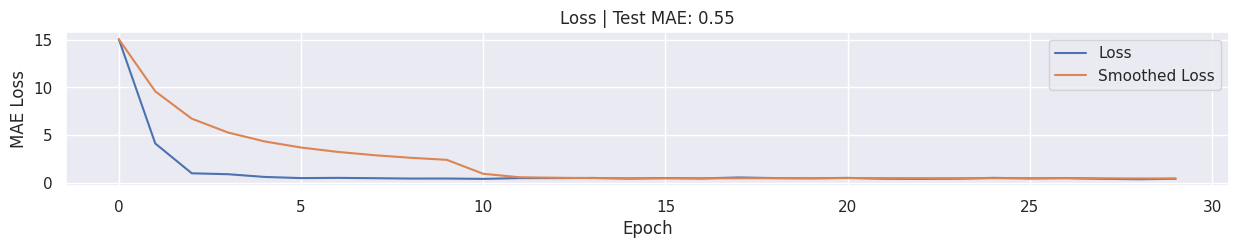

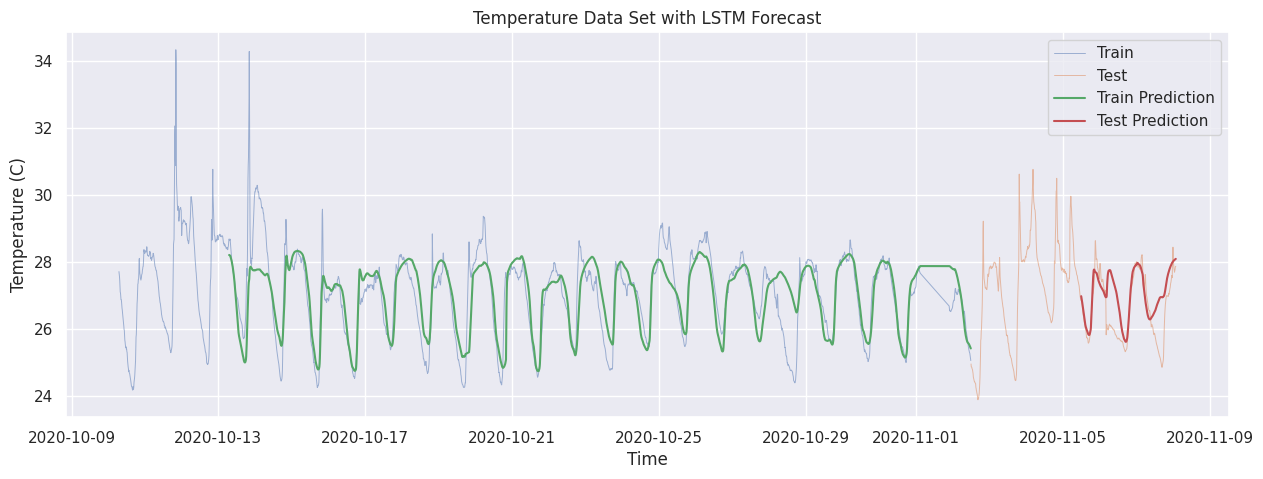

In [18]:
model = AutoFarmModel(hidden_size=100, num_layers=1)

history = model.train_step(train_loader, epochs=30, learning_rate=0.001)

lstm_test_error = model.validate_step(test_loader)

train_pred = model(x_train)[:, -1, :].detach().numpy()
test_pred = model(x_test)[:, -1, :].detach().numpy()

history = pd.DataFrame(history)
history['smoothed_loss'] = history['loss'].rolling(10, min_periods=1).mean()

plt.figure(figsize=(15, 2))
plt.plot(history['epoch'], history['loss'], label='Loss')
plt.plot(history['epoch'], history['smoothed_loss'], label='Smoothed Loss')
plt.title(f'Loss | Test MAE: {lstm_test_error:.2f}')
plt.xlabel('Epoch')
plt.ylabel('MAE Loss')
plt.legend()
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(train['timestamp'], train['ds18b20_air_temp_0'], label='Train', linewidth=0.7, alpha=0.5)
plt.plot(test['timestamp'], test['ds18b20_air_temp_0'], label='Test', linewidth=0.7, alpha=0.5)
plt.plot(train['timestamp'][-len(train_pred[:, -1]):], train_pred[:, -1], label='Train Prediction')
plt.plot(test['timestamp'][-len(test_pred[:, -1]):], test_pred[:, -1], label='Test Prediction')
plt.title('Temperature Data Set with LSTM Forecast')
plt.xlabel('Time')
plt.ylabel('Temperature (C)')
plt.legend()
plt.show()

The LSTM network appears to have done a great job! The best test MAE we have ever had. How well does the model predict results into the future (the ultimate goal of forecasting). From the output, we can see exactly how well it performs. With just 48 hours of lag, the model is able to predict the temperature within half a degrees 24 hours into the future. This is quite impressive! 

Clearly, with no real tuning required, the LSTM network is a powerful model. 

## Conclusion

There is an extraordinary amount of detail that is underneath all the libraries and methodologies I was playing with here. I barely scratched the surface of what is possible. Just for reference on some things I didn't do:

- backtesting training methodologies and how auto-regressive models are trained slicing data in different ways
- Seasonality exploration in auto-regressive models. Even non-time based seasonalities like holidays or events.
- Multi-series forecasting given multiple features (like temperature and humidity)
- The importance and implications of scaling the data! I didn't even touch this but is very important for neural networks.
- Combining CNNs and LSTMs for time series forecasting
- Confidence intervals and how to calculate them.

Time series is just as complex as a task as any other. But it's a very fasinating one as it's literally the exploration of predicting the future. Particularly in an agricultural setting (a setting I have a lot of interest in), there are so many applications for this: predicting the weather, growth of plants, health of soil, harvesting and spraying schedules, and so much more.

There is so much more I want to explore but this is it for now. I hope you enjoyed this notebook and learned something new.